# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

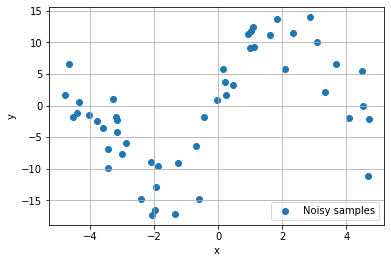

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

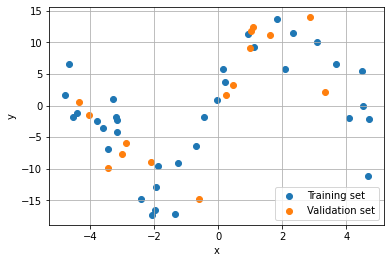

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

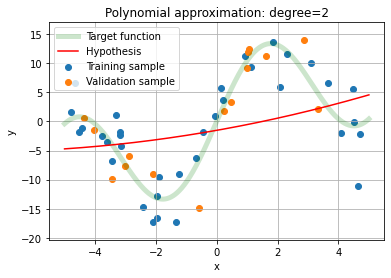

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

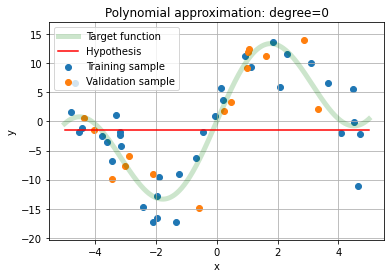

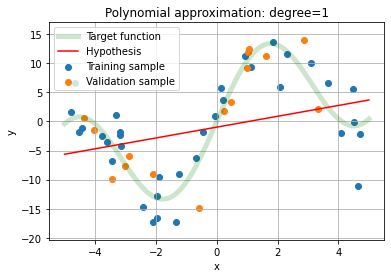

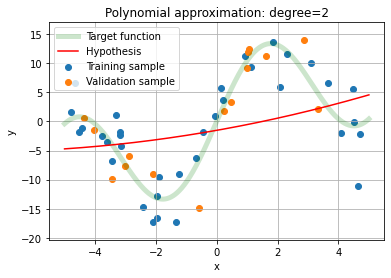

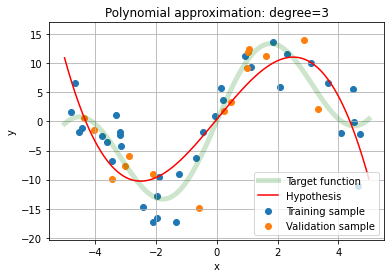

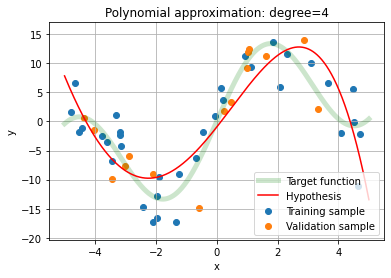

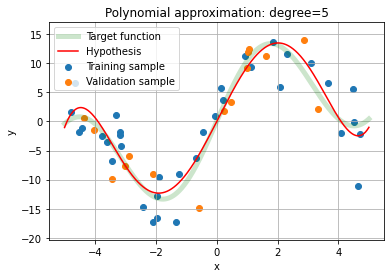

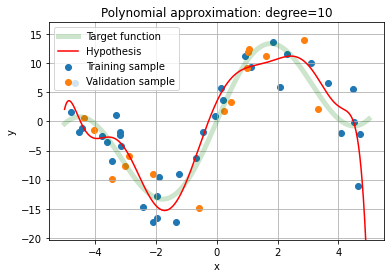

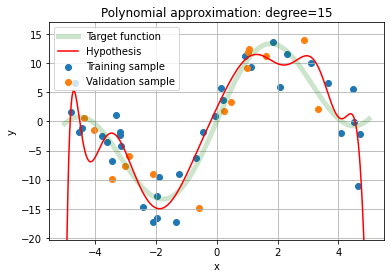

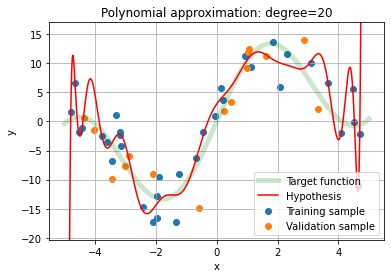

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

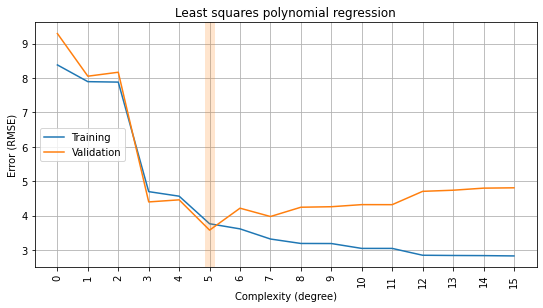

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

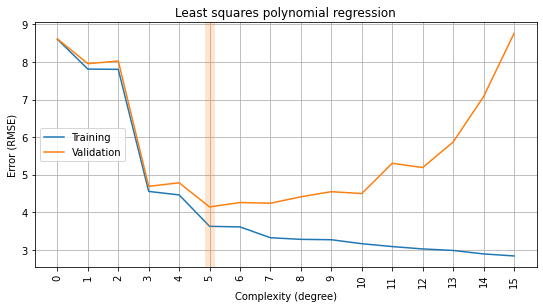

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

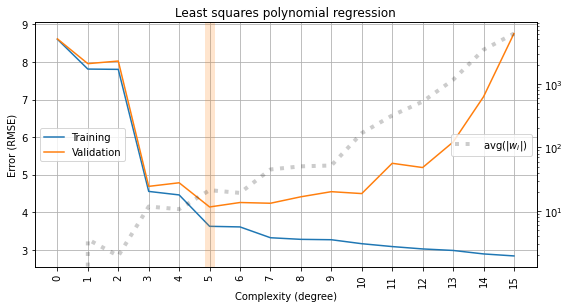

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

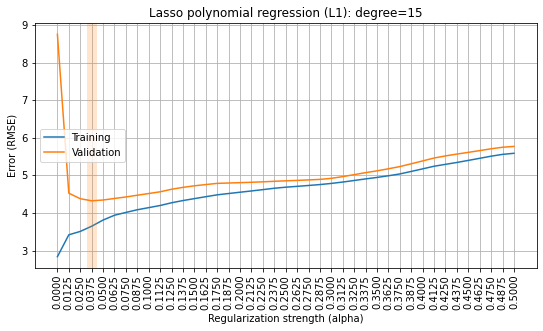

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

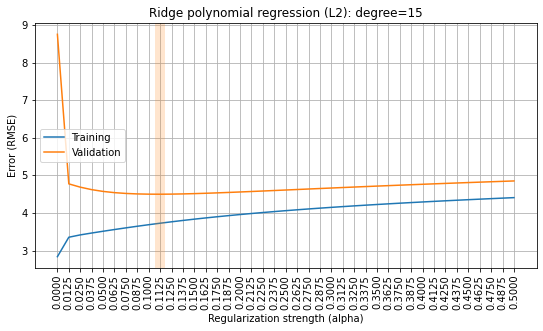

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [21]:
from sklearn.compose import ColumnTransformer

In [25]:
def make_model_opt(degree, alpha=0, penalty=None, polynomial_columns=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    if degree == 0:
        return Pipeline([
            ('1st column', ColumnTransformer([("only first", "passthrough", [0])])),
            ('pol', PolynomialFeatures(0, include_bias=True)),
            ('reg', regressor)
        ])
    
    if polynomial_columns:
        return Pipeline([
            ('pol', ColumnTransformer(
                [("only selected", PolynomialFeatures(degree), polynomial_columns)],
                remainder='passthrough'
            )),
            ('reg', regressor)
        ])
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=False)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

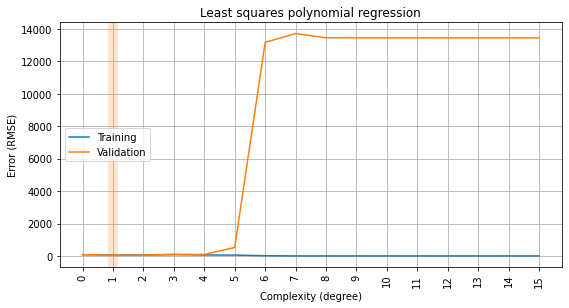

In [26]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model_opt(degree, polynomial_columns=slice(0,5)), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

In [27]:
DEGREES[np.argmin(rmse_valid)]

1

**Results:**  
1. The best test error when degree = 1  
2. When degre = 5, we already see some overfitting. When degree = 6, overfitting is high.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

**Hypothesis:** if regularization methods constraint the weights, the average weight will decrease.  
Let's check it.

In [32]:
def plot_weights(x, weights, metric_valid, xlabel, ylabel, title):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, weights, alpha=0.2, color='navy', lw=4, ls='dotted', label='Weights')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center right')        
    plt.show()

#### L1

Let's use L1 penalty and make calculations. Weights will be averaged over CV folds. We will have weight for each feature for each alpha value and display them on graph.

In [33]:
rmse_train_lasso, rmse_valid_lasso, avg_coef_lasso = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_opt(degree=15, penalty='L1', alpha=alpha, polynomial_columns=slice(0,5)), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_lasso.append(-np.mean(results['train_score']))
    rmse_valid_lasso.append(-np.mean(results['test_score']))
    
    avg_coef_lasso.append(        
        # average over CV folds
        np.mean([np.abs(model['reg'].coef_) for model in results['estimator']], axis=0)
    )

Let's calculate the average weihgt for each alpha value

In [34]:
averaged_weights_lasso = [np.mean(i) for i in avg_coef_lasso]

Display averaged weights according to alpha increasing

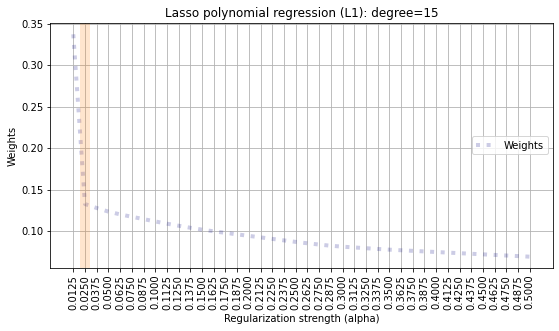

In [35]:
plot_weights(ALPHAS[1:], averaged_weights_lasso[1:], rmse_valid_lasso,
                   xlabel='Regularization strength (alpha)', ylabel='Weights',
                   title='Lasso polynomial regression (L1): degree=15')

#### L2

Let's do the same actions for Ridge regularisation

In [38]:
rmse_train_ridge, rmse_valid_ridge, avg_coef_ridge = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_opt(degree=15, penalty='L2', alpha=alpha, polynomial_columns=slice(0,5)), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_ridge.append(-np.mean(results['train_score']))
    rmse_valid_ridge.append(-np.mean(results['test_score']))
    avg_coef_ridge.append(        
        # average over CV folds
        np.mean([np.abs(model['reg'].coef_) for model in results['estimator']], axis=0)
        )

In [39]:
averaged_weights_ridge = [np.mean(i) for i in avg_coef_ridge]

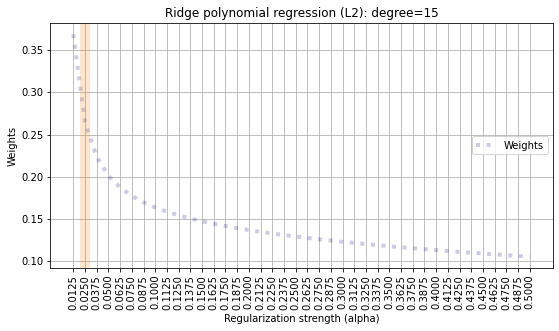

In [40]:
plot_weights(ALPHAS[1:], averaged_weights_ridge[1:], rmse_valid_ridge,
                   xlabel='Regularization strength (alpha)', ylabel='Weights',
                   title='Ridge polynomial regression (L2): degree=15')

In [41]:
def plot_summary(x, lasso, ridge, valid_lasso, valid_ridge, title, y_label):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, lasso, label='Lasso')
    plt.plot(x, ridge, color='C1', label='Ridge')
    plt.axvline(x[np.argmin(valid_lasso)-1], color='C3', lw=10, alpha=0.2, label='Lasso')
    plt.axvline(x[np.argmin(valid_ridge)-1], color='C1', lw=10, alpha=0.2, label='Ridge')
    plt.title(title)
    plt.xlabel('Regularization strength (alpha)', fontsize =10)
    plt.ylabel(y_label, fontsize =10)
    plt.legend()
    plt.grid(True)
    plt.xticks(ALPHAS[1:], rotation='vertical')
    plt.show()

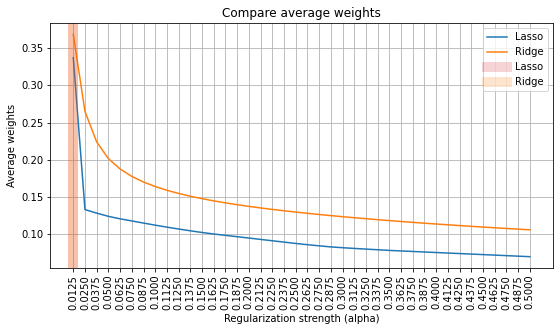

In [42]:
plot_summary(ALPHAS[1:], 
             averaged_weights_lasso[1:], 
             averaged_weights_ridge[1:], 
             rmse_valid_lasso, 
             rmse_valid_ridge,
            'Compare average weights',
            'Average weights')

Looking on the merged graph we can say that Lasso averaged weights decrease more quickly. It obviosly couse of the formulas: absolute values vs squares values.  
Finally, we can say that out hypothesis is true - averaged weights decrese with alpha increasing.

#### Summary

Let's display both graphs with averaged weights on one graph.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

Let's calculate the number of zero weights for each alpha value and put them on the graph

In [43]:
def plot_zero_weights_number(x, zero_weights_number, metric_valid, xlabel, ylabel, title):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, zero_weights_number, color='navy', alpha=0.2, lw=4, ls='dotted', label='Zero Weights Number')
    plt.axvline(x[np.argmin(metric_valid)-1], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center right')        
    plt.show()

#### L1

In [44]:
zero_weights_lasso = [np.count_nonzero(i==0) for i in avg_coef_lasso]

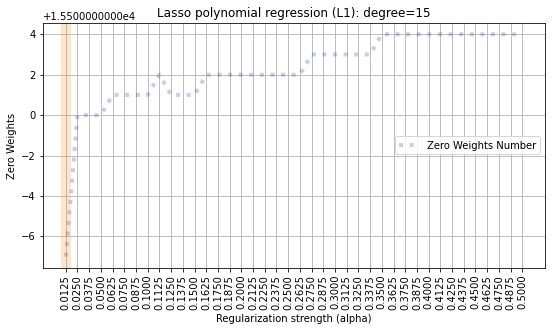

In [45]:
plot_zero_weights_number(ALPHAS[1:], zero_weights_lasso[1:], rmse_valid_lasso,
                         xlabel='Regularization strength (alpha)', ylabel='Zero Weights',
                         title='Lasso polynomial regression (L1): degree=15')

#### L2

Let's calculate the number of zero weights for each alpha for Ridge as well

In [46]:
zero_weights_ridge = [np.count_nonzero(i==0) for i in avg_coef_ridge]

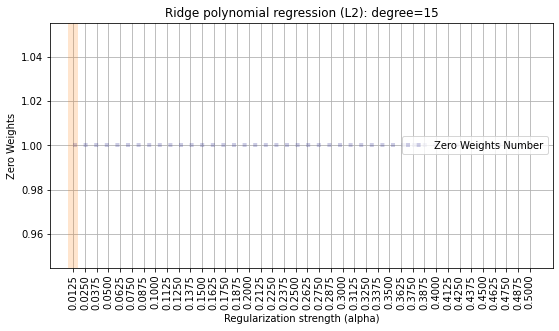

In [47]:
plot_zero_weights_number(ALPHAS[1:], zero_weights_ridge[1:], rmse_valid_ridge,
                         xlabel='Regularization strength (alpha)', ylabel='Zero Weights',
                         title='Ridge polynomial regression (L2): degree=15')

#### Summary

We can say that only L1 regularisation decrease weigths to zero after graphs analysis.
We can also mention that increasing regularization strength provides increasing the number of zero weights. On some alpha the number of zero weigths becomes constant.
At least, optimal alfa does not correspond either minimal number or maximum number of zero weigths.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

Often attributes are not expressed by the same standards, scales or measures, to such an extent that their statistics yield distorted data modeling results.
So, if one of the attributes has a broad range of values, the computed distance will be skewed by this attribute (i.e. smaller valued attribute will contribute very little). For example, if one of the attributes is measured in centimeters, and one then decided to convert the measure to millimeters (i.e. multiplying the values by 10), the result can be significantly affected. To have the attribute adds approximately proportionately to the final computed distance, the range of that attribute should be standardized

Standardisation or Z-score normalisation is a scaling technique whereby the values in a column are rescaled so that they demonstrate the properties of a standard Gaussian distribution, that is mean = 0 and variance = 1.

X_new = (X - mean) / std

StandardScaler is the Scikit-learn function for standardisation.

Standardisation is generally preferred in most machine learning context as it is especially important in order to compare the similarities between features based on certain distance measures. This is most prominent in Principal Component Analysis (PCA) where we are interested in the components that maximise the variance.

Let's try to use StandardScaler on some dataset.

In [48]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [49]:
standard = StandardScaler()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_hw, y_hw, train_size = 0.7, random_state = 42)

In [51]:
X_train_scaled = standard.fit_transform(X_train)
X_test_scaled = standard.transform(X_test)

#### L1

In [52]:
lr = Lasso()

In [53]:
lr_mse = []
# Without feature scaling
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
lr_mse.append(mean_squared_error(y_test, pred))

#With scaling
lr.fit(X_train_scaled, y_train)
pred_scaled = lr.predict(X_test_scaled)
lr_mse.append(mean_squared_error(y_test, pred_scaled))

# Show results     
lr_df = pd.DataFrame({'MSE': lr_mse}, index = ['Original', 'StandardScaler'])
lr_df

,MSE
Original,37.701372
StandardScaler,12.583714


#### L2

In [54]:
ridge = Ridge(alpha=0.05, random_state=42, max_iter=50000)

In [55]:
ridge_mse = []
# Without feature scaling
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
ridge_mse.append(mean_squared_error(y_test, pred))

#With scaling
ridge.fit(X_train_scaled, y_train)
pred_scaled = ridge.predict(X_test_scaled)
ridge_mse.append(mean_squared_error(y_test, pred_scaled))

# Show results     
ridge_df = pd.DataFrame({'MSE': ridge_mse}, index = ['Original', 'StandardScaler'])
ridge_df

,MSE
Original,25.083949
StandardScaler,16.436501


#### Summary



1. Polinomial featuring helps to make models better, but high degrees leeds to overfitting.
2. Lasso regression produces zero coefficients, Ridge doesn't.  
[Some explanation](https://online.stat.psu.edu/stat508/lesson/5/5.4#:~:text=The%20lasso%20performs%20shrinkage%20so,axis%20is%20shrunk%20to%20zero)  
I think that Lasso can be used as a feature selection.
3. Scaling is really helpful for datasets that have attributes which are not expressed by the same standards.  